# BENG 212 HW 3

##  Name: Kinshuk Sahu

### 2/4/2020

Resources: Special topics in statistics
 - https://www.bmj.com/specialties/statistics-notes
 - https://www.nature.com/collections/qghhqm/content/statistics-in-biology 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

data = pd.read_excel('Homework_Data.xlsx', sheet_name = 'Expression Data', index_col = 0)
metadata = pd.read_excel('Homework_Data.xlsx', sheet_name = 'Experimental Conditions', index_col = 0)
gene_info = pd.read_excel('Homework_Data.xlsx', sheet_name = 'Gene Information', index_col = 0)

In [2]:
import scipy as sp
from scipy import interpolate


def estimate(pv, m=None, verbose=False, lowmem=False, pi0=None):
    """
    Estimates q-values from p-values
    Args
    =====
    m: number of tests. If not specified m = pv.size
    verbose: print verbose messages? (default False)
    lowmem: use memory-efficient in-place algorithm
    pi0: if None, it's estimated as suggested in Storey and Tibshirani, 2003.
         For most GWAS this is not necessary, since pi0 is extremely likely to be
         1
    """
    assert(pv.min() >= 0 and pv.max() <= 1), "p-values should be between 0 and 1"

    original_shape = pv.shape
    pv = pv.ravel()  # flattens the array in place, more efficient than flatten()

    if m is None:
        m = float(len(pv))
    else:
        # the user has supplied an m
        m *= 1.0

    # if the number of hypotheses is small, just set pi0 to 1
    if len(pv) < 100 and pi0 is None:
        pi0 = 1.0
    elif pi0 is not None:
        pi0 = pi0
    else:
        # evaluate pi0 for different lambdas
        pi0 = []
        lam = sp.arange(0, 0.90, 0.01)
        counts = sp.array([(pv > i).sum() for i in sp.arange(0, 0.9, 0.01)])
        for l in range(len(lam)):
            pi0.append(counts[l]/(m*(1-lam[l])))

        pi0 = sp.array(pi0)

        # fit natural cubic spline
        tck = interpolate.splrep(lam, pi0, k=3)
        pi0 = interpolate.splev(lam[-1], tck)
        if verbose:
            print(("qvalues pi0=%.3f, estimated proportion of null features " % pi0))

        if pi0 > 1:
            if verbose:
                print(("got pi0 > 1 (%.3f) while estimating qvalues, setting it to 1" % pi0))
            pi0 = 1.0

    assert(pi0 >= 0 and pi0 <= 1), "pi0 is not between 0 and 1: %f" % pi0

    if lowmem:
        # low memory version, only uses 1 pv and 1 qv matrices
        qv = sp.zeros((len(pv),))
        last_pv = pv.argmax()
        qv[last_pv] = (pi0*pv[last_pv]*m)/float(m)
        pv[last_pv] = -sp.inf
        prev_qv = last_pv
        for i in range(int(len(pv))-2, -1, -1):
            cur_max = pv.argmax()
            qv_i = (pi0*m*pv[cur_max]/float(i+1))
            pv[cur_max] = -sp.inf
            qv_i1 = prev_qv
            qv[cur_max] = min(qv_i, qv_i1)
            prev_qv = qv[cur_max]

    else:
        p_ordered = sp.argsort(pv)
        pv = pv[p_ordered]
        qv = pi0 * m/len(pv) * pv
        qv[-1] = min(qv[-1], 1.0)

        for i in range(len(pv)-2, -1, -1):
            qv[i] = min(pi0*m*pv[i]/(i+1.0), qv[i+1])

        # reorder qvalues
        qv_temp = qv.copy()
        qv = sp.zeros_like(qv)
        qv[p_ordered] = qv_temp

    # reshape qvalues
    qv = qv.reshape(original_shape)

    return qv

## Problem 1: P-values and Statistical Significance

### A. Read "Mindless Statistics"

https://www.sciencedirect.com/science/article/pii/S1053535704000927

i.Define (in words) a p-value, statistical significance, and statistical power

 A p value is defined as the probability of the observation occuring given that the null hypothesis is true. Statistical significance is pre defined by the user (denoted by 𝛼), and signifies the cutoff below which we can reject the null hypothesis. Statistical power is defined as the ratio of true positive and true postive plus false negative, denoting the amount of actual signal that is present in the data. Typically, we first set a null hypothesis and and an alternate hypothesis, and then calculate the probability that the sampling distribution came from the original distribution specified by the null hypothesis.(p value). If this value is lower than a certain level(statisticacl significance) then we reject the null hypothesis and select the alternate hypothesis. The null ritual as the author says is defining a null hypothesis but no alternate hypothesis, and using 5% as significance for rejecting the null and perfroming this procedure mechanically without thinking.

ii. Fisher’s work developing p-values and the Neyman-Pearson work on statistical significance were originally separate developments but have become combined in common practice in hypothesis testing in science. Describe and contrast the two schools of thought. To which school of thought do the concepts of Type I and Type II error belong?

Fischer's work termed the null hypothesis testing involves first setting up a null hypothesis and then reporting the exact level of significane without accepting or rejecting hypothesis. He also said that this procedure should be performed only as a preliminary test on the data. Neyman and Pearson's work called the decision theory involved testing up two different hypothesis(H1 and H2), and specifying the level of alpha, beta and the number of samplings beforehand. Then we see the actual data whether it falls in the rejection region of H1. If it does then we accept the alternate hypothesis (H2) or else we accept the original one(H1). Fischers work doesn't incorporate any alternate hypothesis unlike Neyman-Pearson. Also because of this type II error rates are not incorporated in the Fischer's hypothesis, it only belongs to the Neyman Pearson work. Type I error rates or the number of false positives, which crops up when the null hypothesis is true but we reject that hypothesis, is stated explicitly in Neyman Pearson works but it exists in Fischer framework too since it deals with the null/original hypothesis.But later on Fischer criticised that Type I and Type II error are "absurdly academic" practices, since he said to report the exact level of significance opposed to a cutoff. For Fischer the level of significance was a property of the data since every sampled data reported a p value associated with it but Neyman-Pearson 𝛼 is a propery of the test instead. 


iii. The author presents six True/False questions (in section 4). Explain the answer to each of these questions.

a) False We can never conclude for certain that our null hypothesis is false unless the p value will be absoloute zero, which will never arise in a statistical distribution
b) False The null hypothesis testing involves calculating the probabaility that the sampled data relates to the one specified by the null hypothesis, provided null hypothesis is true. It is a conditional probability. We will never now by this method if our hypothesis on the first place was true or not, so we cannot prove or disprove that.
c) False As in a we can never conclude that our experimental hypothesis is absolutely correct unless the p value is absolute zero, which will never happen. 
d) False We cannot an unconditional probability with null hypothesis testing since it is based on a condition, null hypothesis being true. Although this can be done using Bayesian statistics.
e) False We would know the probability that we are making the wrong decision if we knew beforehand if null hypothesis was true or not. Which is not the case since in null hypothesis testing we are considering a conditional probability.
f) False This statement is also hinged on the probability whether the null hypothesis is true or not which cannot be calculated in null hypothesis testing. 

### B. Define Family Wise Error Rate and False Discovery Rate in the context of controlling type I error.

Family Wise Error rate is defined as the probablity of finding at least one false positive error in number of times the statistical error test is applied. False discovery rate is the ratio of false positives to false positives plus true positives, indicating the amount of result(positives) that is actually true. To control type I error that is the number of false positives in an error test, we can apply techniques based on reducing the family wise error rate or reducing the false discovery rate. For example in Bonferonni correction we only reject at p<α/n where n is the number of times we are doing the test. This technique tries to reduce the FWER although it is conservative and reduces the power, ie there will be less TP and more FN than before. False Discovery rate based approaches like pFDR divide the data into a background distribution and a true signal, and tries instead to reduce the number of false positives, meaning there will be some false postive value allowed unlike FWER where we try to reduce all the false positives cropping up in any of the tests. 

### C. Generate a list of p-values to answer the question: Which genes significantly change their expression when the amount of glucose in the media is doubled from 2 g/L to 4 g/L? Use a non-parametric statistical test. What does your p-value distribution look like, and how many tests (genes) are significant (p < 0.05) without multiple comparison correction?

In [3]:
#sample indexing according to carbon sources 

Carbon_2=metadata.index[metadata['Carbon Source (g/L)']== 'glucose(2)']
Carbon_4=metadata.index[metadata['Carbon Source (g/L)']== 'glucose(4)']


b0002      4.378164e-01
b0003      8.843330e-01
b0004      1.404323e-01
b0005      8.355516e-07
b0006      7.754019e-02
               ...     
b4688      8.766672e-04
b4693      1.596371e-01
b4696_1    4.626027e-03
b4696_2    3.850278e-03
b4705      1.814465e-01
Length: 3887, dtype: float64


Text(0, 0.5, 'Number of genes')

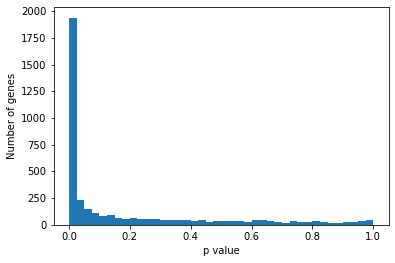

In [4]:
from scipy.stats import mannwhitneyu as mnu
p=[]
for gene in data.index:
    Carbon_2_values=data.loc[gene,Carbon_2] 
    Carbon_4_values=data.loc[gene,Carbon_4]
    
    p+=[mnu(Carbon_2_values,Carbon_4_values,alternative='two-sided')[1]]
p=pd.Series(p,index=data.index)
print(p)
plt.hist(p,bins=40)
plt.xlabel('p value')
plt.ylabel('Number of genes')

Our p value distribution looks like an exponential decay function.Compared to a normal distribution , the data is skewed heavily to the left and is very sharp too.  We find that almost close to 2000 genes show a p value less than 0.01. If the significance level chosen were to be 0.01, then these 2000 genes would reject the null hypothesis and indicate that the changes are significant. 

### D. Now, correct your list of p-values for multiple comparisons using the following methods and discuss which gene-cluster associations are ‘accepted’ in each set of corrected values.

- FWER methods
    - Bonferroni
    - Holm-Bonferroni Step-Down
- FDR methods
    - Benjamini-Hochburg Step-up
    - Storey method to calculate q-values


b0952    4.675912e-12
b0965    6.575488e-12
b1709    1.687216e-11
b4263    1.803441e-11
b4058    2.351940e-11
             ...     
b2600    1.000000e+00
b1876    1.000000e+00
b0387    1.000000e+00
b2762    1.000000e+00
b4497    1.000000e+00
Length: 3887, dtype: float64
[1.27794604e-08 1.27794604e-08 1.75249394e-08 ... 1.00000000e+00
 1.00000000e+00 1.00000000e+00]
[1.27794604e-08 1.27794604e-08 1.75249394e-08 ... 1.00000000e+00
 1.00000000e+00 1.00000000e+00]
Significant genes by bonferroni correction are Index(['b0952', 'b0965', 'b1709', 'b4263', 'b4058', 'b0220', 'b4139', 'b0325',
       'b2672', 'b2137',
       ...
       'b2447', 'b0192', 'b0947', 'b2166', 'b2912', 'b0231', 'b1257', 'b4033',
       'b3607', 'b3624'],
      dtype='object', length=542)
Significant genes by Holm Bonferroni correction are Index(['b0952', 'b0965', 'b1709', 'b4263', 'b4058', 'b0220', 'b4139', 'b0325',
       'b2672', 'b2137',
       ...
       'b0403', 'b3318', 'b0595', 'b3964', 'b0596', 'b3496', 'b3874

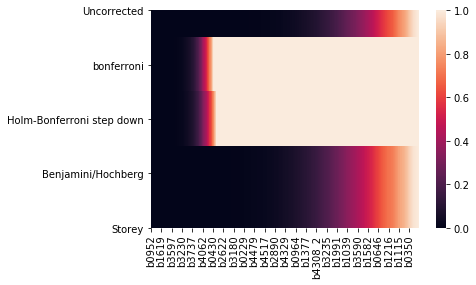

In [54]:
from statsmodels.stats import multitest as mt
import seaborn as sns
# family wise error rate models
p=p.sort_values()
P_bon=mt.multipletests(p,alpha=0.05,method='bonferroni')[1]
P_holm=mt.multipletests(p,alpha=0.05,method='holm')[1]
# false discovery rate models
P_benjhoch=mt.multipletests(p,alpha=0.05,method='fdr_bh')[1]
P_storey=estimate(p,pi0=1)
print(p)
print(P_storey)
print(P_benjhoch)

# now visualising which genes are significant 
#doing with heatmaps 

P_allcorrected=np.array([p.values,P_bon,P_holm,P_benjhoch,P_storey])
P_allcorrected_pd=pd.DataFrame(P_allcorrected,columns=p.index,index=['Uncorrected','bonferroni','Holm-Bonferroni step down','Benjamini/Hochberg','Storey'])
ax = sns.heatmap(P_allcorrected_pd)


# printing out the genes which indicate significance in each correction

P_bon_pd=pd.Series(P_bon,index=p.index)
print("Significant genes by bonferroni correction are",P_bon_pd[P_bon_pd<0.05].index)

P_holm_pd=pd.Series(P_holm,index=p.index)
print("Significant genes by Holm Bonferroni correction are",P_holm_pd[P_holm_pd<0.05].index)

P_benjhoch_pd=pd.Series(P_benjhoch,index=p.index)
print("Significant genes by Benjamin Hoch correction are",P_benjhoch_pd[P_benjhoch_pd<0.05].index)

P_storey_pd=pd.Series(P_storey,index=p.index)
print("Significant genes by Storey correction are",P_storey_pd[P_storey_pd<0.05].index)





We observe that the FWER corrections involving bonferroni and holm bonferroni tremendously reduce the amount of significant genes, which is obvious due to its theoretical definition of being a low power and overly  conservative algorithm. Benjamini Hochberg and storey(FDR methods) on the other hand show slight reduction in the number of significant genes as compared to the uncorrected but it is SIGNIFICANTLY greater than the one given by FWER(1950 in FDR vs 553 and 542 in Holm bonferroni and bonferroni)

## Problem 2. Probability Distributions

### A. What is a probability density function? What is a moment?

A probability density function explains the various values that a random variable can take(support),and with what probabilities. ex- the maximum temperature in a city can be described as a random variable and the proabilities with which it can take values in the support is decribes by the probability density function(pdf). A moment decribes how the shape of a function is, in this case the shape of a probability density function. The zeroth moment is the total probability, the first moment is the expected value of the pdf, the second moment(central) is the variance, the third standardised moment is the skewness, and the fourth moment is the kurtosis. 

### B. Assess the gene expression data in Homework_Data.xlsx. Calculate the mean, variance, skew, and kurtosis of the flattened data (all samples combined).  What do the skewness and kurtosis values tell us about the distribution in this case?

In [16]:
from scipy.stats import describe as db
flat_data=data.stack()
print(flat_data.values)
flat_data_mean=db(flat_data.values)[2]
flat_data_variance=db(flat_data.values)[3]
flat_data_skewness=db(flat_data.values)[4]
flat_data_kurtosis=db(flat_data.values)[5]
print(flat_data_mean,flat_data_variance,flat_data_skewness,flat_data_kurtosis)

[7.62931651 7.71493807 8.11334677 ... 0.         0.         0.        ]
3.9148548260796803 3.34995525521457 0.08924480617090558 -0.442984202979555


The value of the skewness is pretty close to zero. This indicates that the data is not skewed towards right or left when compared to a normal distribution, and hence the distribution is pretty symmetric. The slight negative values of kurtosis indicates that the shape of the distribution is slightly flat and the distribution is said to be platykurtic with respect to kurtosis. The underlying distribution of the data will be slightly flatter than the normal distribution(N.D), with lighter tails and the data will be less error prone to outliers compared to a N.D. 

### C. Compare the mean and variance of each sample to robust estimators of central tendency and dispersion, respectively. 

This can be done with a pair of scatter plots and a brief explanation.

Text(0.5, 1.0, 'Analysing robust method of dispersion')

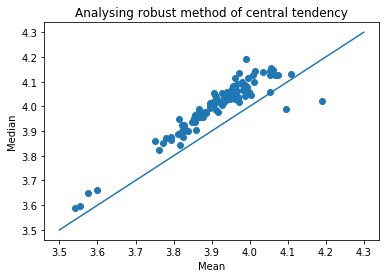

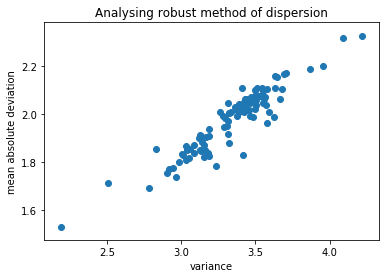

In [44]:
# so we calculate the mean, median, variance and mean absolute deviation across all the rows of the original data
from scipy.stats import median_absolute_deviation as mad
data_mean=db(data.values,axis=0)[2]
data_variance=db(data.values,axis=0)[3]
data_mad=mad(data.values,axis=0)
data_median=data.median(axis=0)

#PLotting mean and median
fig=plt.subplots()
plt.scatter(data_mean,data_median)
plt.xlabel('Mean')
plt.ylabel('Median')
plt.title('Analysing robust method of central tendency')
plt.plot(np.linspace(3.5,4.3),np.linspace(3.5,4.3)) # just doing to analyse how it compares with mean=median

#variance and mad
fig=plt.subplots()
plt.scatter(data_variance,data_mad)
plt.xlabel('variance')
plt.ylabel('mean absolute deviation')
plt.title('Analysing robust method of dispersion')
# plt.xlim(1.5,4.5)
# plt.xlim(1.5,4.5)
# plt.plot(np.linspace(1.5,4.5),np.linspace(1.5,4.5))



We see that for most of the samples, there is a larger median than the mean, a physical signifance of which is there is a long tail to left pulling down mean than median.So it indicates many genes aren't expressed at all or expressed in low values. Also the variance is more than the median absolute deviation for most data points. This is also since there are a lot of low values of expression of some genes under a particular sample condition increasing the variance. This plot also indicates that mad and median are better measures of central tendency and dispersion if the data doesn't follow a normal distribution, since mean and variance are affected by "outliers".

### D. Assess whether the data follows a normal distribution using a quantile-quantile plot.

[ 2.02944333  2.07622375  2.2938994  ... -2.13893066 -2.13893066
 -2.13893066]


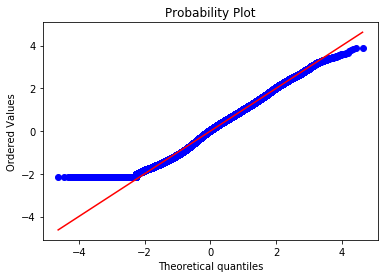

In [51]:
import pylab 
import scipy.stats as stats

# first we stack the data
flat_data=data.stack()
#now normalize the data 
data_norm = stats.zscore(flat_data)
print(data_norm)                         
stats.probplot(data_norm,dist="norm",plot=pylab)
pylab.show()

We observe that the two distribution, one assumed the normal distribution and one assumed our sample distribution(shown by ordered values), almost lie on the line y=x. This indicates the distribution of these 2 funtions, the normal distibution and the sample distributions is almost similar. They have almost common location and scale since the line is not shifted from the y=x line. Also the tail behaviour can be observed with our data having lower values compared to the normal distribution seen in the extremes of left and right of the graph. So our sampled data has thicker tails compared to the N.D.

### E. Identify (or create) examples of how the following distributions might occur in analysis of biological data:
 - Poisson
 - Normal
 - Uniform


Poisson distribution can occur when we are modelling a stochastic version of cell growth dynamics(prokaryotic). Here each cell produces Ki offspring in the next generation where each Ki is a poisson distributed r.v. Other examples include the probability of finding a restiction enzyme site in a given DNA sequence and the arrival of spike trains in an axon from different neurons via the synapse etc. Normal distribution might occur for example in gene expression data at a particular condition when done in replicates, or when we are seeing the effect of population charecteristics, for example the weight of all the mices used in a drug study etc. Uniform distribution might occur for example if we define the random variable to take discrete values A, T, G, C then if the function is the chance to find one of them in a single position in the DNA sequence then it is unifromly distributed over these 4 discrete values. Other examples include the probability of finding different types of microbe species in a mircobiome(define first the support as only microbes that are found in the microbiome) etc. 

## Problem 3: Bayesian Statistics
Resources:
- “What is Bayesian Statistics”: https://www.nature.com/articles/nbt0904-1177.pdf 
- Bayesian Statistics primers from Nature Methods: 
    - https://www.nature.com/articles/nmeth.3368 
    - https://www.nature.com/articles/nmeth.3335 

### A. Derive Bayes Theorem for the probability that “A” is true, given that “B” is true. Hint: Start from two ways of writing the probability of A and B both occurring. (Of course, following one of the many derivations available on the internet and in textbooks is fine.)

Note that equations can be written in jupyter notebooks using latex:

$$ y = ax^{2} + bx + c $$

We know that conditional probability that A has occured given B is given by:
<br>
$ P(A/B)=P(A \cap B)/P(B) $
<br>
$P(A \cap B)=P(A/B). P(B)$ ---1)
<br>
Alternatively prob that B has occured given A is given by:
<br>
$ P(B/A)=P(A \cap B)/P(A) $
<br>
$P(A \cap B)=P(B/A). P(A)$ ---2)
<br>
equating RHS of eqns 1) and 2) since LHS is similar
<br>
$P(B/A). P(A)=P(A/B). P(B)$
<br>
$P(A/B)=(P(B/A). P(A)) / P(B)$
<br>
Hence proved

### B. How does Bayesian thinking of probability of an alternative hypothesis occurring differ from frequentist use of p-values? What is the Bayes Factor and how does it compare to a p-value? 

A frequentist approach involves calculating the probabilty that the data is observed given that the hypothesis is true opposed to the Bayesian thinking involves the calculation that probability that the hypothesis is true given the data observed. Unlike frequentist, Bayesian approach requires defining an alternative hypothesis beforehand and also a prior distribution that gets evaluated. Bayes factor is defined as the ratio of the probability that the data is true given an alternate hypothesis to the ratio that the probability that the data is true given the null hypothesis(H0). A Bayes factor of 10 indicates a strong evidence for the alternate hypothesis(H1) and a Bayes factor of 3-5 indicates a moderate evidence for H1. Bayes factor of 1 indicates no evidence of the data to follow H1. This ratio when simplified involves using the reverse probability described in the 1st sentence. 

Bayes factor= $\frac {P(D/H_1)}{P(D/H_0)}= \frac {P(H_1/D).P(H_O)}{P(H_0/D).P(H_1)} $

### C. Define the prior and posterior distributions and how they are determined.

A prior distribution is the probability of observing some entity, if r.v defines all the values of the support which it can take, the probability distribution of that random variable is the prior distribution. The starting prior distribution must be determined beforehand by the user themselves, the choice of what one chooses must be done carefully. Posterior probablity reprensents the probability that is calculated after taking the data into account, it is given by P(H/D), calulated using Bayes theorem. We update the prior based on the posterior for the next iteration and then calculate the posterior once again. This is repeated until one acheives the desired accuracy. 

